Statistical errors of CNN models

#read current
#load model and calculate out put od model
#plot 3d error of Bfield

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn.functional as F
if torch.cuda.device_count():
    device = 'cuda'
    map_location = 'cuda:0'
    print('Good to go')
else:
    device = 'cpu'
    map_location = torch.device('cpu')
    print('Using cpu')
    
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset

Good to go


In [2]:
#load saved  model
num_input = 12
output_shape = (3,16,16,16)
SB_args = (64,64,4) # (Cin, Cout, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
Generative_network = torch.load('EMS_CNN.pt', map_location=map_location)
Generative_network.eval()
Generative_network.to(device)

Generative_net(
  (proj): Linear(in_features=12, out_features=4096, bias=True)
  (conv3d): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (total_net): Sequential(
    (0): Linear(in_features=12, out_features=4096, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 4, 4, 4))
    (2): BigBlock(
      (block): Sequential(
        (0): ResidualEMNSBlock_3d(
          (conv3d): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(negative_slope=0.01)
          )
          (block): Sequential(
            (0): Sequential(
              (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (2): LeakyReLU(negative_slope=0.01)
            )
         

In [3]:
#load current and real magnetic field data
from ReadData import ReadCurrentAndField_CNN
foldername="./Data/"
filenum=1400
filepattern = "MagneticField[0-9]*.txt"
current,data = ReadCurrentAndField_CNN (foldername,filepattern,filenum)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
position = data[:,0:3,2:18,2:18,2:18]
Bfield = data[:,3:,2:18,2:18,2:18]
#data normalization
min_current=torch.load("./normalize_data/cnn_min_current.pt")
max_current=torch.load("./normalize_data/cnn_max_current.pt")
min_Bfield=torch.load("./normalize_data/cnn_min_Bfield.pt")
max_Bfield=torch.load("./normalize_data/cnn_max_Bfield.pt")

dimB = Bfield.shape
dimc = current.shape
print(min_current.shape)
print(min_Bfield.shape)

minB=min_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)
maxB=max_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)

ave_current=0.5*(max_current.expand(dimc[0],dimc[1])+min_current.expand(dimc[0],dimc[1]))
diff_current=0.5*(max_current.expand(dimc[0],dimc[1])-min_current.expand(dimc[0],dimc[1]))

current_norm = (current-ave_current)/diff_current
Bfield_norm = (Bfield-(minB+maxB)*0.5)/(0.5*(maxB-minB))

print(current_norm.shape)
print(Bfield_norm.shape)


torch.Size([1, 12])
torch.Size([3, 1])
torch.Size([1400, 12])
torch.Size([1400, 3, 16, 16, 16])


In [11]:
num_samples, num_current_input = current.shape
_, dimension, grid_x, grid_y, grid_z = Bfield.shape
grid_space = grid_x*grid_y*grid_z
print(grid_x)
print("current shape:",current.shape,"current device:",current.device)
print("Bfied;:",Bfield.shape,"current device:",Bfield.device)

16
current shape: torch.Size([1400, 12]) current device: cpu
Bfied;: torch.Size([1400, 3, 16, 16, 16]) current device: cpu


In [12]:
#calculate estimated normalized Bfield value of CNN 
train_file_num=1300
B_est_norm=torch.zeros(num_samples,dimension,grid_x,grid_y,grid_z)
for i in range (0,num_samples):
    input=current_norm[i,:].to(device).reshape(1,12)
    b = input.float()
    B_est_norm[i]=Generative_network(b)

B_est=B_est_norm*(0.5*(maxB-minB))+0.5*(maxB+minB)
#calculate rmse 
mse_test = F.mse_loss(B_est[train_file_num:,:],Bfield[train_file_num:,:],reduction='sum')
rmse_test = torch.sqrt(mse_test/100/grid_space)

mse_train = F.mse_loss(B_est[0:train_file_num,:],Bfield[0:train_file_num,:],reduction='sum')
rmse_train = torch.sqrt(mse_train/train_file_num/grid_space)


B_est=B_est.cpu().detach().numpy()
B_est_norm=B_est_norm.cpu().detach().numpy()
Bfield_norm=Bfield_norm.detach().numpy()
current_norm=current_norm.detach().numpy()
Bfield=Bfield.cpu().detach().numpy()


In [13]:
print(B_est_norm.shape)
print(f'rmse_train={rmse_train*1000:.2f}mT')
print(f'rmse_teat={rmse_test*1000:.2f}mT')
Bdiff_norm=np.absolute(B_est_norm-Bfield_norm)
print(Bdiff_norm.shape)
Error_CNN = Bdiff_norm/np.absolute(Bfield_norm+1e-5)*100
print(B_est.shape)
print(Bfield.shape)

(1400, 3, 16, 16, 16)
rmse_train=35.03mT
rmse_teat=34.80mT
(1400, 3, 16, 16, 16)
(1400, 3, 16, 16, 16)
(1400, 3, 16, 16, 16)


tensor(0.2814)
tensor(0.6344)
torch.Size([1400, 12])


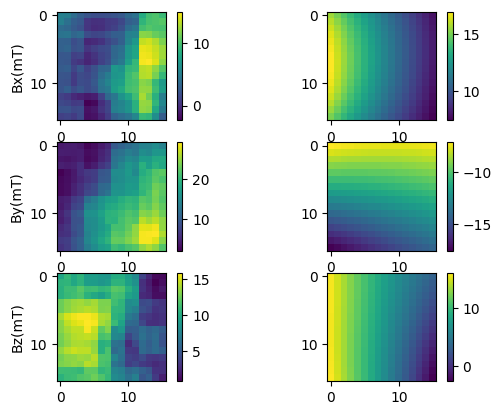

example RMSE: tensor(0.0290)
my RMSE: 0.029024210585235893


<Figure size 640x480 with 0 Axes>

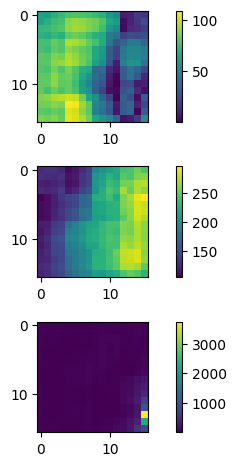

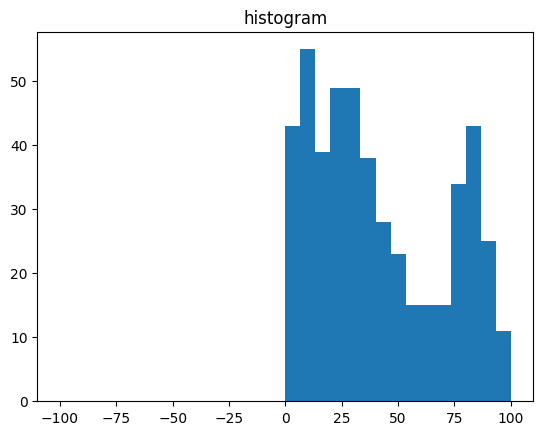

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
loss_norm = F.l1_loss(torch.tensor(B_est_norm),torch.tensor(Bfield_norm))

mse_norm = F.mse_loss(torch.tensor(B_est_norm),torch.tensor(Bfield_norm),reduction='sum')
rmse_norm = torch.sqrt(mse_norm/num_samples/grid_space)

print(loss_norm)
print(rmse_norm)
current_index = 8
print(current.shape)

z_plane_index= 11
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
vmin=[-8,7,-12]
vmax=[-1 , 17, -2]
MSE_temp = 0
my_error = 0

ylables=['Bx(mT)','By(mT)','Bz(mT)']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    B_est_temp = B_est[current_index,i-1,:,:,z_plane_index]
    # B_est_temp = B_est[current_index,i-1,:,:,:]
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est_temp*1000)    #,vmin=vmin[i-1],vmax=vmax[i-1]
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    Bfield_temp = Bfield[current_index,i-1,:,:,z_plane_index]
    # Bfield_temp = Bfield[current_index,i-1,:,:,:]*1000
    plt.subplot(3,2,2*i)
    plt.imshow(Bfield_temp*1000)
    plt.colorbar()
    # print('B_est_temp:',B_est_temp)
    # print('Bfield_temp:',Bfield_temp)
    MSE_temp += F.mse_loss(torch.tensor(B_est_temp),torch.tensor(Bfield_temp),reduction='sum')
    my_error += np.sum((B_est_temp-Bfield_temp)**2)

plt.show()
RMSE_temp = torch.sqrt(MSE_temp/grid_x/grid_y)
RMSE_my = np.sqrt(my_error/grid_x/grid_y)
print('example RMSE:',RMSE_temp)
print('my RMSE:', RMSE_my)
from pylab import *
subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
fig, ax = plt.subplots(3, 1)
fig.tight_layout()

for i in range(1,4):
    plt.subplot(3,1,i)
    plt.imshow(Error_CNN[current_index,i-1,:,:,z_plane_index])    
    plt.colorbar(fraction=0.04)    

plt.show()

plt.hist(Error_CNN[current_index,:,:,:,z_plane_index].reshape(-1),bins=30,range=[-1.0e2,1.0e2])
plt.title("histogram") 
plt.show()

In [9]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
a=a[0:2,:]
print(a)
print(a.shape)




[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [4 5 6]]
(2, 3)
